In [76]:
import pyautogui
import time
from threading import Timer
import threading
import os
import numpy as np
import pytesseract
from PIL import ImageGrab
import math
pytesseract.pytesseract.tesseract_cmd=r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
from easyocr import Reader
from types import GeneratorType
import re
import cv2
import pygetwindow as gw
import json
from PIL import Image
from operator import itemgetter
from functools import wraps
from types import GeneratorType
import keyboard
import logging
import PIL
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s')

profile = {
    "name": "default profile",
    "agent_type": "nikke",
    "desc": "a default template for Nikke helper",
    "settings":{
        "load_to_memory":True,
        "active_window": "BlueStacks Keymap Overlay"
    },
    "routine": {
        "1":{
            "name":"claim_outpost_reward",
            "display_name": "Claim Outpost Reward",
            "frequency": "daily",
            "priority": 2,
            "auto":True,
            "settings":{
            }
        },
        "2":{
            "name":"claim_friend_points",
            "display_name": "Claim Friend Points",
            "priority": 1,
            "frequency": "daily",
            "auto":True,
            "settings":{
            }
        },
        "3":{
            "name":"advise_nikke",
            "display_name": "Advise Nikke",
            "priority": 3,
            "frequency": "daily",
            "auto":True,
            "settings":{
            }
        },
        "4":{
            "name":"event",
            "display_name": "Repeat Event Levels",
            "priority": 4,
            "frequency": "daily",
            "auto":False,
            "settings":{
                "level_to_repeat":"1-11"
            }
        }, 
        "5":{
            "name":"rookie_arena",
            "display_name": "Rookie Arena",
            "priority": 5,
            "frequency": "daily",
            "auto":True,
            "settings":{
                "max_power_gap": 1000
            }
        }
    }
}

## Nikke Agent

In [77]:
class LocationBox:
    def __init__(self, left=0, top=0, width=0, height=0, box=None, _box=None, points=None):
        if box:
            left = box.left
            top = box.top
            width = box.width
            height = box.height
        elif _box:
            left = _box._left
            top = _box._top
            width = _box._width
            height = _box._height
        elif points:
            loc = self.points_to_loc(points)
            left = loc.left
            top = loc.top
            width = loc.width
            height = loc.height

        self.left = left
        self.top = top
        self.width = width
        self.height = height

    def points_to_loc(self, points):
        x_coordinates, y_coordinates = zip(*points)
        return LocationBox(min(x_coordinates),
                           min(y_coordinates),
                           max(x_coordinates)-min(x_coordinates),
                           max(y_coordinates) - min(y_coordinates))

    def to_array(self):
        return [self.left, self.top, self.width, self.height]

    def to_bounding(self):
        return [self.left, self.top, self.left+self.width, self.top+self.height]

    def translate(self, x, y):
        return LocationBox(self.left+x, self.top+y, self.width, self.height)

    def resize(self, width, height):
        return LocationBox(self.left, self.top, width, height)

    def coord(self):
        return np.array([self.left, self.top])

    def size(self):
        return np.array([self.width, self.height])

    def stretch(self, value, axis=0, direction="right", in_place=False):
        new_box = LocationBox(box=self)
        if axis == 0:
            new_box.width += value
            if direction == "left":
                new_box.left -= value
        elif axis == 1:
            new_box.height += value
            if direction == "up":
                new_box.top -= value

        if in_place:
            if axis == 0:
                new_box.width -= self.width
                if direction == "left":
                    new_box.left -= self.width
                elif direction == "right":
                    new_box.left += self.width

            elif axis == 1:
                new_box.height -= self.height
                if direction == "up":
                    new_box.top -= self.height
                elif direction == "down":
                    new_box.top += self.height

        return new_box

    def __repr__(self):
        return f'LocationBox(left={self.left}, top={self.top}, width={self.width}, height={self.height})'


In [199]:
class GameInteractionIO:
    bounce_key_delay = 0.07
    inter_key_delay = 0.1
    post_action_delay = 1
    language = ['en', 'ch_sim']
    reader = Reader(language)

    def post_action_generator(delay):
        def post_action(function):
            @wraps(function)
            def wrapper(*args, **kwargs):
                retval = function(*args, **kwargs)
                GameInteractionIO.delay(delay)
                return retval
            return wrapper
        return post_action

    post_action = post_action_generator(post_action_delay)

    def to_cv2(image):
        return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    def to_pil(image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(image)
        return im_pil

    def switch_active_application(app_name, app_loc=None):
        app_list = [""]
        if not app_loc:
            app_list = GameInteractionIO.get_available_applications(
                verbose=True)
        else:
            app_list = gw.getWindowsAt(
                *GameInteractionIO.get_image_center(app_loc))
        app = [app for app in app_list if app.title == app_name][0]
        if app:
            app.activate()
        else:
            return False
        return True

    def resize_application(app_name, app_loc=None, size=None):
        app_list = [""]
        if not app_loc:
            app_list = GameInteractionIO.get_available_applications(
                verbose=True)
        else:
            app_list = gw.getWindowsAt(
                *GameInteractionIO.get_image_center(app_loc))

        app = [app for app in app_list if app.title == app_name][0]
        if app and size:
            app.resizeTo(*size)
        else:
            return False
        return True

    def get_available_applications(verbose=False):
        app_list = [app for app in pyautogui.getAllWindows()
                    if app.title != ""]
        if not verbose:
            app_list = [app.title for app in app_list]
        return app_list

    def stretch_white_space(image):
        white_space = np.array([[255]*(image.shape[1])]*2)
        p = np.concatenate((white_space, image))

        a = np.array([[255]*(p.shape[0])]).T
        prev = 0
        empty_count = 5
        count = 0
        digit = []
        for ind in range(p.shape[1]):
            if np.mean(p[:, ind]) == 255:
                a = np.concatenate((a, p[:, prev:ind+1]), axis=1)
                a = np.concatenate((a, np.array([p[:, ind]]*11).T), axis=1)
                if np.mean(p[:, prev:ind+1].flatten()) != 255:
                    digit.append(np.array(p[:, prev:ind+1], dtype=np.uint8))
                prev = ind
                count += 1
                if count > empty_count:
                    break
            else:
                count = 0
        a = a.astype(np.uint8)
        return a, digit

    def preprocess_image(image, threshold='global'):
        """
        preprocess a PIL image to make it more visible for text recognition
        """
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if threshold == 'global':
            ret, thresh = cv2.threshold(gray, 110, 255, cv2.THRESH_BINARY)
            new_image = thresh
        elif threshold == 'adaptive':
            thresh = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 2)
            erode = cv2.erode(thresh, np.array((7, 7)), iterations=1)
            new_image - erode
        return new_image

    def preprocess_image_number(image):
        """
        preprocess a PIL image to make it more visible for text recognition
        """
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 110, 255, cv2.THRESH_BINARY)
        erode = cv2.erode(thresh, np.array((9, 9)), iterations=1)
        stretch_image, digit = GameInteractionIO.stretch_white_space(erode)
        return stretch_image

    def read_text(image_name, model_name=None, detail=1, in_line=True):
        if not model_name:
            model_name = GameInteractionIO.reader

        frame = cv2.cvtColor(np.array(image_name), cv2.COLOR_RGB2BGR)

        # Read the data
        result = model_name.readtext(frame, detail=detail, paragraph=in_line)
        return result

    def _read_number(image, l=0, im_type=6):
        if l == 0:
            value = pytesseract.image_to_string(image,
                                                config=f'--psm {im_type} outputbase digits tessedit_char_whitelist=0123456789').strip().replace(" ", "")
        elif l == 1:
            image = GameInteractionIO.preprocess_image_number(image)
            value = pytesseract.image_to_string(image,
                                                config=f'--psm {im_type} outputbase digits tessedit_char_whitelist=0123456789').strip().replace(" ", "")

        value = re.sub('[^A-Za-z0-9]+', '\n', value)
        if not value.isdigit():
            return False
        value = int(value)
        return value

    def read_number(image, l=0):
        """
        image types
        #   0    Orientation and script detection (OSD) only.
        #   1    Automatic page segmentation with OSD.
        #   2    Automatic page segmentation, but no OSD, or OCR.
        #   3    Fully automatic page segmentation, but no OSD. (Default)
        #   4    Assume a single column of text of variable sizes.
        #   5    Assume a single uniform block of vertically aligned text.
        #   6    Assume a single uniform block of text.
        #   7    Treat the image as a single text line.
        #   8    Treat the image as a single word.
        #   9    Treat the image as a single word in a circle.
        #  10    Treat the image as a single character.
        #  11    Sparse text. Find as much text as possible in no particular order.
        #  12    Sparse text with OSD.
        #  13    Raw line. Treat the image as a single text line,
        #             bypassing hacks that are Tesseract-specific.
        """
        value = False
        im_type_list = [6, 7, 8, 9, 10, 11, 12, 13]
        value_list = []
        for im_type in im_type_list:
            value = GameInteractionIO._read_number(image, l, im_type)
            if value:
                value_list.append(value)
        if not value:
            value = GameInteractionIO.read_text(image, detail=0)
            if value:
                value = value[0]
                value = re.sub('[^A-Za-z0-9]+', '\n', value)
                if value.isdigit():
                    value = int(value)
                    value_list.append(value)
        if len(value_list) > 0:
            value = max(value_list)
        return value

    def repeat_press(key, hold_time):
        start_time = time.time()
        while time.time() - start_time < hold_time:
            pyautogui.press(key)

    def hold_key(key, hold_time):
        pyautogui.keyDown(key)
        print('holding %s' % key)
        time.sleep(hold_time)
        pyautogui.keyUp(key)

    def hold_key_combo(keydown, key):
        pyautogui.keyDown(keydown)
        pyautogui.keyDown(key)
        time.sleep(GameInteractionIO.inter_key_delay)
        pyautogui.keyUp(key)
        pyautogui.keyUp(keydown)

    def double_click(key):
        print('double clicking %s' % key)
        pyautogui.keyDown(key)
        time.sleep(GameInteractionIO.bounce_key_delay)
        pyautogui.keyUp(key)
        time.sleep(GameInteractionIO.inter_key_delay)
        pyautogui.keyDown(key)
        time.sleep(GameInteractionIO.bounce_key_delay)
        pyautogui.keyUp(key)

    def single_click(key):
        print('single clicking %s' % key)
        pyautogui.keyDown(key)
        time.sleep(GameInteractionIO.bounce_key_delay)
        pyautogui.keyUp(key)

    def scroll(distance):
        pyautogui.scroll(distance)
        time.sleep(GameInteractionIO.inter_key_delay)

    def mouse_right_click(cursor_coord=[None, None]):
        pyautogui.click(*cursor_coord, clicks=1, interval=1, button='right')

    def mouse_left_click(cursor_coord=[None, None]):
        pyautogui.click(*cursor_coord, clicks=1, interval=1, button='left')

    def mouse_right_double_click(cursor_coord):
        pyautogui.click(*cursor_coord, clicks=2, interval=0.1, button='right')

    def mouse_left_double_click(cursor_coord):
        pyautogui.click(*cursor_coord, clicks=2, interval=0.1, button='left')

    def mouse_multiclick(cursor_coord, clicks=2, interval=0.1, button='left'):
        pyautogui.click(*cursor_coord, clicks=clicks,
                        interval=interval, button='left')

    def delay(delay_time):
        if delay_time < 0:
            delay_time = 0
        time.sleep(delay_time)

    def get_image_center(location):
        return np.array([location.left + location.width//2, location.top + location.height//2])

    def get_window_info(logo_path, resolution):
        window_corner_location = GameInteractionIO.locate_image(
            logo_path, confidence=0.9)
        if not window_corner_location:
            return None
        offset = [-3, -4, 0, 20]
        # offset = [-3, 16, 0, 0]
        x_min = window_corner_location.left + offset[0]
        width = resolution[0] + offset[2]
        y_min = window_corner_location.top + offset[1]
        height = resolution[1] + offset[3]
        window_info_array = [x_min, y_min, width, height]
        window_info_location = LocationBox(*window_info_array)
        return window_info_location

    def _rmse(measured, truth):
        rmse = np.linalg.norm(measured - truth) / np.sqrt(len(truth))
        return rmse

    def _remove_duplicated_location_once(image_location_list, threshold=0.1):
        if not image_location_list:
            return image_location_list
        il_prev = image_location_list[0]
        new_image_location_list = [il_prev]
        for il in image_location_list[1:]:
            if abs(il.top - il_prev.top) > il.height*threshold or abs(il.left - il_prev.left) > il.width*threshold:
                new_image_location_list.append(il)
                il_prev = il
        return new_image_location_list

    def _remove_duplicated_location(image_location_list, threshold=0.1):
        if not image_location_list:
            return image_location_list

        new_image_location_list = GameInteractionIO.non_maximum_suppresion(
            image_location_list, threshold=threshold)

        return new_image_location_list

    def non_maximum_suppresion(loc_list, threshold=0.4):
        boxes = np.array([loc.to_bounding() for loc in loc_list])
        # Return an empty list, if no boxes given
        if len(boxes) == 0:
            return []
        x1 = boxes[:, 0]  # x coordinate of the top-left corner
        y1 = boxes[:, 1]  # y coordinate of the top-left corner
        x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
        y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
        # Compute the area of the bounding boxes and sort the bounding
        # Boxes by the bottom-right y-coordinate of the bounding box
        # We add 1, because the pixel at the start as well as at the end counts
        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        # The indices of all boxes at start. We will redundant indices one by one.
        indices = np.arange(len(x1))
        for i, box in enumerate(boxes):
            # Create temporary indices
            temp_indices = indices[indices != i]
            # Find out the coordinates of the intersection box
            xx1 = np.maximum(box[0], boxes[temp_indices, 0])
            yy1 = np.maximum(box[1], boxes[temp_indices, 1])
            xx2 = np.minimum(box[2], boxes[temp_indices, 2])
            yy2 = np.minimum(box[3], boxes[temp_indices, 3])
            # Find out the width and the height of the intersection box
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)
            # compute the ratio of overlap
            overlap = (w * h) / areas[temp_indices]
            # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index
            if np.any(overlap) > threshold:
                indices = indices[indices != i]
        # return only the boxes at the remaining indices
        return [loc_list[ind] for ind in indices]

    def locate_image(image_path, master_image_path=None, confidence=0.8, region=None, multi=False, multi_threshold=0.3):
        if isinstance(image_path, list):
            location_list = []
            for im in image_path:
                if master_image_path:
                    if multi:
                        image_location = pyautogui.locateAll(
                            im, master_image_path, confidence=confidence)
                    else:
                        image_location = pyautogui.locate(
                            im, master_image_path, confidence=confidence)
                else:
                    if multi:
                        image_location = pyautogui.locateAllOnScreen(
                            im, confidence=confidence, region=region)
                    else:
                        image_location = pyautogui.locateOnScreen(
                            im, confidence=confidence, region=region)
                if image_location is not None:
                    if isinstance(image_location, GeneratorType):
                        image_location = [LocationBox(
                            *il) for il in image_location]
                        image_location = GameInteractionIO._remove_duplicated_location(
                            image_location, threshold=multi_threshold)
                    elif image_location is not None:
                        image_location = LocationBox(*image_location)
                    location_list.append(image_location)
            return location_list
        else:
            if master_image_path:
                if multi:
                    image_location = pyautogui.locateAll(
                        image_path, master_image_path, confidence=confidence)
                else:
                    image_location = pyautogui.locate(
                        image_path, master_image_path, confidence=confidence)
            else:
                if multi:
                    image_location = pyautogui.locateAllOnScreen(
                        image_path, confidence=confidence, region=region)
                else:
                    image_location = pyautogui.locateOnScreen(
                        image_path, confidence=confidence, region=region)
            if isinstance(image_location, GeneratorType):
                image_location = [LocationBox(*il) for il in image_location]
                image_location = GameInteractionIO._remove_duplicated_location(
                    image_location, threshold=multi_threshold)
            elif image_location is not None:
                image_location = LocationBox(*image_location)
            return image_location if image_location else None

    def exist_image(image_path, master_image_path=None, confidence=0.8, region=None, loop=False, timeout=10):
        image_location = None
        if isinstance(image_path, list):
            location_list = []
            if loop is True:
                wait_time = 0
                while image_location is None and wait_time < timeout:
                    for im in image_path:
                        if master_image_path:
                            image_location = pyautogui.locate(
                                im, master_image_path, confidence=confidence)
                        else:
                            image_location = pyautogui.locateOnScreen(
                                im, confidence=confidence, region=region)
                        if image_location is None:
                            GameInteractionIO.delay(1)
                            wait_time += 1
                            break
                if image_location is None:
                    return False
            else:
                for im in image_path:
                    if master_image_path:
                        image_location = pyautogui.locate(
                            im, master_image_path, confidence=confidence)
                    else:
                        image_location = pyautogui.locateOnScreen(
                            im, confidence=confidence, region=region)
                    if image_location is None:
                        return False
        else:
            if loop is True:
                wait_time = 0
                while image_location is None and wait_time < timeout:
                    if master_image_path:
                        image_location = pyautogui.locate(
                            image_path, master_image_path, confidence=confidence)
                    else:
                        image_location = pyautogui.locateOnScreen(
                            image_path, confidence=confidence, region=region)
                    if image_location is None:
                        GameInteractionIO.delay(1)
                        wait_time += 1
                        break
                if image_location is None:
                    return False
            else:
                if master_image_path:
                    image_location = pyautogui.locate(
                        image_path, master_image_path, confidence=confidence)
                else:
                    image_location = pyautogui.locateOnScreen(
                        image_path, confidence=confidence, region=region)
                if image_location is None:
                    return False
        return True

    def move_to_image_location(location, alignment='center'):
        image_cord = [location.left, location.top]
        if alignment == 'center':
            image_cord[0] += location.width//2
            image_cord[1] += location.height//2
        pyautogui.moveTo(*image_cord)

    def get_direction(source_location, destination_location):
        source_center = GameInteractionIO.get_image_center(source_location)
        destination_center = GameInteractionIO.get_image_center(
            destination_location)
        direction = destination_center - source_center
        return direction

    def get_coord(location):
        return np.array([location.left, location.top])

    def mouse_center(window_center):
        pyautogui.moveTo(*window_center)

    def mouse_center_click(image_location):
        window_center = GameInteractionIO.get_image_center(image_location)
        pyautogui.click(*window_center, clicks=1, interval=1, button='left')

    def locate_image_and_double_click(image_path, region_im=None, region_location=None, region=None, button='left'):
        """
        locate an image and double click it
        default using left click
        """
        image_location = GameInteractionIO.locate_image(
            image_path, region_im, confidence=0.8, region=region)
        if not image_location:
            return False
        image_coord = GameInteractionIO.get_image_center(image_location)
        if region_location is not None:
            image_coord += region_location.coord()
        pyautogui.click(*image_coord, clicks=2, interval=1, button=button)
        return True

    @post_action
    def locate_image_and_click(image_path, region_im=None, region_location=None, confidence=0.8,
                               region=None, button='left', loop=False, timeout=10, delay=1):
        """
        locate an image and double click it
        default using left click
        """
        image_location = GameInteractionIO.locate_image(
            image_path, region_im, confidence=confidence, region=region)
        if loop is True:
            wait_time = 0
            while not image_location and wait_time < timeout:
                GameInteractionIO.delay(delay)
                image_location = GameInteractionIO.locate_image(
                    image_path, region_im, confidence=confidence, region=region)
                wait_time += 1
        if not image_location:
            return False
        if isinstance(image_location, list):
            image_location = image_location[0]
        image_coord = GameInteractionIO.get_image_center(image_location)
        if region_location is not None:
            image_coord += region_location.coord()
        if button:
            pyautogui.click(*image_coord, clicks=1, interval=1, button=button)
        return True

    def get_region_location_first_time(region_image_path, window_info):
        """
        based on the given image path, get the relative location of the image in
        the screen w.r.t. the window's center coord 
        """
        region_abs_location = GameInteractionIO.locate_image(
            region_image_path, confidence=0.9, region=window_info)
        region_offset = GameInteractionIO.get_coord(
            region_abs_location) - GameInteractionIO.get_image_center(window_info)
        region_offset_location = LocationBox(
            *region_offset,
            *region_abs_location.size())
        return region_offset_location

    def get_region_location(region_location_offset, window_center_coord):
        """
        based on the region's offset location and the window's center coord
        get the region's current active location
        """
        left = region_location_offset.left + window_center_coord[0]
        top = region_location_offset.top + window_center_coord[1]
        return LocationBox(left, top, *region_location_offset.size())

    def get_sub_region_location(sub_region_offset, region_offset, window_center_coord):
        """
        based on subregion's offset to windows center coord reference and the region's offset to window center coord
        get the subregion's offset location relative to the region's location
        """
        sub_region_location_coord = window_center_coord - \
            region_offset.coord() + sub_region_offset.coord()
        sub_region_location = LocationBox(
            *sub_region_location_coord,
            *sub_region_offset.size()
        )
        return sub_region_location

    def get_location_image(image_location, region_image=None):
        """
            take a screenshot of the image location screen
            if a region_image is provided, use tha region image as the screen instead
        """
        if region_image is not None:
            location_im = region_image.crop(image_location.to_bounding())
        else:
            location_im = ImageGrab.grab(bbox=image_location.to_bounding())
        return location_im


 2023-02-19 17:38:29,460 - WARNING - CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [200]:
gio = GameInteractionIO

In [218]:
class Agent:
    def retry_action(timeout=3, delay=3):
        def post_action(function):
            @wraps(function)
            def wrapper(*args, **kwargs):
                attempt = 0
                while attempt < timeout:
                    try:
                        retval = function(*args, **kwargs)
                        return retval
                    except Exception as e:
                        print(e)
                        gio.delay(delay)
                return None
            return wrapper
        return post_action

    def __init__(
        self,
        app_name=None,
        profile=None,
        profile_path=None,
        game_settings=None,
        game_settings_path=None
    ):
        # set logging
        self.set_logger()

        # load up the profile
        self.load_profile(profile=profile, profile_path=profile_path)

        # Load up game settings
        self.load_game_settings(profile=game_settings,
                                profile_path=game_settings_path)

        # set the active window region
        self.initialize_game(app_name)

    def _sort_dict_by_value(self, unsorted_dict, value):
        """
        helper function to sort a dictionary by the values of it's sub dictionaries
        """
        return {k: v for k, v in sorted(unsorted_dict.items(), key=lambda item: item[1][value])}

    def set_logger(self):
        self.logger = logging.getLogger(
            '==============NIKKE DEBUGGER=============')
        self.logger.setLevel(logging.DEBUG)

    def initialize_game(self, app_name=None):
        # initialize all features
        self.default_resolution = [575, 1022]
        self.default_real_resolution = [591, 1061]
        self.default_advise_nikke_stretch_length = 250
        self.image_path = 'images'
        self.NIKKE_PC_WINDOW = 'NIKKE'
        self.NIKKE_PC_SCROLL_CONSTANT = 13
        self.init_location_map()
        self.set_active_window(app_name)
        self.setup_image_profile()
        self.set_game_settings()
        return True

    def select_active_window(self, app_name=None):
        if not app_name:
            app_name = self.settings.get('active_window')
        self.set_active_window(app_name)
        self.setup_image_profile()
        self.set_game_settings()
        return True

    def resize_image(self, im):
        new_resolution = self.resolution
        if new_resolution != self.default_resolution:
            ratio = new_resolution[1]/self.default_resolution[1]
            im = im.resize((round(s*ratio) for s in im.size))
        return im

    def resize_value(self, value):
        new_resolution = self.resolution
        if new_resolution != self.default_resolution:
            ratio = new_resolution[1]/self.resolution[1]
            value = value*ratio
        return value

    def load_image_path(self, image_path):
        image_path_dict = {}

        for root, dirs, files in os.walk(image_path):
            if root[-1] != "\\":
                root = root+"\\"
            sub_dir = root.replace(image_path+'\\', '')
            for file in files:
                if file.endswith('.png') or file.endswith('.PNG'):
                    pretty_name = "_".join(os.path.join(
                        sub_dir, file).split('.')[0].split('\\'))
                    if self.settings['load_to_memory'] is True:
                        image_path_dict[pretty_name] = self.resize_image(
                            Image.open(os.path.join(root, file)))
                    else:
                        image_path_dict[pretty_name] = os.path.join(root, file)
        return image_path_dict

    def setup_image_profile(self):
        """
        load the matching images
        """
        current_path = os.getcwd()
        image_dir_name = self.image_path
        agent_dir_name = self.type

        image_path = os.path.join(current_path, image_dir_name, agent_dir_name)
        self.image_map = self.load_image_path(image_path=image_path)
        return True

    def set_parameters(self):
        self.settings['rookie_arena'] = self.get_rookie_arena_settings()

    def init_location_map(self):
        self.location_map = {}
        return True

    def set_active_window(self, app_name=None):
        """
        set the current active window info
        """
        if not app_name:
            if self.settings.get('active_window'):
                app_name = self.settings.get('active_window')
            else:
                app_name = "BlueStacks Keymap Overlay"

        # get all apps open
        app_list = gio.get_available_applications(verbose=True)

        # find the selected app by name
        app = [app for app in app_list if app.title == app_name]

        if len(app) == 0:
            self.resolution = self.default_resolution
            self.logger.error('cannot find active game window')
            return False
        app = app[0]

        self.settings['active_window'] = app_name

        # record the app location
        app_location = LocationBox(_box=app._rect)

        if app_name == self.NIKKE_PC_WINDOW:
            self.logger.info('Detected PC version of Nikke')
            title_height = 39
            edge_width = 8

            app_location = app_location.stretch(-title_height, axis=1, direction='down'
                                                ).translate(0, title_height-edge_width
                                                            ).stretch(-edge_width*2, axis=0, direction='left'
                                                                      ).translate(-edge_width, 0)

        self.location_map['home'] = app_location

        self.resolution = [app_location.width, app_location.height]
        self.res_multi = self.resolution[1]/self.default_resolution[1]
        print('succesfully detected app window')
        return True

    def load_profile(self, profile=None, profile_path=None):
        """
        load the skill profile for a given agent based on either a skill_path or a skill profile
        if none provided, the profile will be initialized to the default profile from the default skill 
        """
        if not profile_path:
            default_profile_path = 'agent\\default\\default_nikke_profile.json'
            current_path = os.getcwd()
            profile_path = os.path.join(current_path, default_profile_path)

        if not profile:
            with open(profile_path) as f:
                profile = json.load(f)

        self.profile_path = profile_path
        self.profile_name = profile.get('name', 'unknown name')
        self.desc = profile.get('desc', 'unknown desc')
        self.routine = profile.get('routine', 'unknown routine')
        self.type = profile.get('agent_type', 'unknown type')
        self.settings = profile.get('settings', 'unknown settings')

        print('Loaded profile {}'.format(self.profile_name))

    def load_game_settings(self, profile=None, profile_path=None):
        """
        load the skill profile for a given agent based on either a skill_path or a skill profile
        if none provided, the profile will be initialized to the default profile from the default skill 
        """
        if not profile_path:
            default_profile_path = 'agent\\default\\game_settings.json'
            current_path = os.getcwd()
            profile_path = os.path.join(current_path, default_profile_path)

        if not profile:
            with open(profile_path) as f:
                profile = json.load(f)

        setting_type = 'default'
        self.game_settings = profile.get(setting_type)
        print(f'loaded {setting_type} game settings')

    def set_game_settings(self, setting_type='default'):
        # if resolution changed, modify all game related variables that would change with resolution
        settings = self.game_settings
        if self.res_multi != 1:
            m = self.res_multi
            for module, content in self.game_settings.items():
                for s_type, setting in content.items():
                    if s_type == 'var':
                        for k, v in setting.items():
                            setting[k] = round(v*m)
        self.game_settings = settings
        return True

    def save_profile(self):
        profile = {}
        profile['name'] = self.profile_name
        profile['desc'] = self.desc
        profile['routine'] = self.routine
        profile['agent_type'] = self.type
        profile['settings'] = self.settings

        with open(self.profile_path, 'w') as json_file:
            json.dump(profile, json_file, indent=4)
        self.logger.info(f'Succesfully saved profile to {self.profile_path}')

    def focus(self):
        return gio.switch_active_application(app_name=self.settings['active_window'], app_loc=self.location_map['home'])

    def resize(self, resolution=None):
        if not resolution:
            resolution = self.default_real_resolution
        gio.resize_application(app_name=self.settings['active_window'],
                               app_loc=self.location_map['home'],
                               size=resolution)
        self.select_active_window()
        return True

    def resize_to_optimal(self):
        self.resize(resolution=self.default_real_resolution)

    def is_home(self):
        pass

    def terminate_action(self):
        raise KeyboardInterrupt

    def back(self):
        gio.single_click('esc')

    def exit_to_home(self):
        self.logger.info('Exiting to home...')
        potential_actions = [self.image_map['home_outpost_express_reward'],
                             self.image_map['home_outpost_express_confirm'],
                             self.image_map['home_outpost_express_level_up']]

        # click on first available action to exit the outpost express claim panel
        if gio.locate_image_and_click(potential_actions,
                                      region=self.location_map['home'].to_bounding(), loop=True, timeout=2):
            return True
        if gio.locate_image_and_click(self.image_map['home_flash_sale'],
                                      region=self.location_map['home'].to_bounding(), loop=True, timeout=2):
            if gio.locate_image_and_click(self.image_map['confirm'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=2):
                return True

        if gio.locate_image_and_click(self.image_map['back_home'],
                                      region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            return True
        else:
            item_list = [self.image_map['home_blabla'],
                         self.image_map['home_friend'], self.image_map['home_union']]
            self.focus()
            while gio.exist_image(item_list, region=self.location_map['home'].to_bounding()) is False:
                gio.single_click("esc")
                gio.delay(1)
            return True

    def scroll(self, scroll_distance=100, direction='down', delay=2, time=1):
        if self.settings['active_window'] == self.NIKKE_PC_WINDOW:
            time = time*self.NIKKE_PC_SCROLL_CONSTANT

        direction_multiplier = 1 if direction == 'up' else -1
        gio.move_to_image_location(self.location_map['home'])
        for _ in range(time):
            gio.scroll(direction_multiplier*scroll_distance)
        gio.delay(delay)

    def claim_outpost_reward_wipe(self):
        """
            try to do outpost wipe
        """
        self.logger.info('Checking if outpost wipe is available')
        wipe_count = 0
        # return to home if not on the page and enter the screen
        if not gio.locate_image(self.image_map['home_outpost_express_wipe'],
                                region=self.location_map['home'].to_bounding()):
            self.exit_to_home()
            gio.locate_image_and_click(self.image_map['home_outpost_express'],
                                       region=self.location_map['home'].to_bounding(), confidence=0.8)

        gio.locate_image_and_click(self.image_map['home_outpost_express_wipe'],
                                   region=self.location_map['home'].to_bounding(), loop=True, timeout=2)
        # if the wipe is free
        if not gio.locate_image(self.image_map['home_outpost_express_wipe_gem'],
                                region=self.location_map['home'].to_bounding()):
            if gio.locate_image_and_click(self.image_map['home_outpost_express_wipe_wipe'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=2):
                wipe_count += 1

        self.logger.info(f'Performed {wipe_count} outpost wipe')
        self.exit_to_home()

    def claim_outpost_reward(self):
        """
            claim the rewards for the outposts
        """
        self.logger.info("claiming outpost reward start")

        # click on outpost
        gio.locate_image_and_click(self.image_map['home_outpost_express'],
                                   region=self.location_map['home'].to_bounding(), confidence=0.8)

        # click on get reward
        gio.locate_image_and_click(self.image_map['home_outpost_express_obtain_reward'],
                                   region=self.location_map['home'].to_bounding(), loop=True)

        # different pop ups could happen depending on whether
        # 1. there's reward
        # 2. there's no reward ready
        # 3. there's a level up
        potential_actions = [self.image_map['home_outpost_express_reward'],
                             self.image_map['home_outpost_express_confirm'],
                             self.image_map['home_outpost_express_level_up']]

        # click on first available action to exit the outpost express claim panel
        gio.locate_image_and_click(potential_actions,
                                   region=self.location_map['home'].to_bounding(), loop=True)

        # try to do outpost wipe if possible
        self.claim_outpost_reward_wipe()

        self.logger.info("claiming outpost reward end successful")

        self.exit_to_home()

    def claim_friend_points(self):
        """
        claim all existing friendship points
        """
        self.logger.info("claiming friend points start")

        # click on friendship icon
        gio.locate_image_and_click(self.image_map['home_friend'],
                                   region=self.location_map['home'].to_bounding())

        # wait for the friendlist to refresh
        gio.exist_image(self.image_map['home_friend_send_ready'],
                        region=self.location_map['home'].to_bounding(), loop=True)

        # TODO: Might want to make this into a setting
        gio.delay(2)  # usually friendship takes sometime to refresh

        # if you can still send/receive points, do it and confirm
        if not gio.exist_image(self.image_map['home_friend_send_not_ready'],
                               region=self.location_map['home'].to_bounding(), loop=True, timeout=2):
            gio.locate_image_and_click(self.image_map['home_friend_send'],
                                       region=self.location_map['home'].to_bounding(), loop=True)
            gio.locate_image_and_click(self.image_map['confirm'],
                                       region=self.location_map['home'].to_bounding())

        self.logger.info("claiming friend points end")
        self.exit_to_home()

    @retry_action()
    def advise_check_available_session(self):
        ADVISE_AMOUNT_TEXT_1 = '咨询次数'
        ADVISE_AMOUNT_TEXT_2 = '追踪妮姬'
        available_advise_session = 0
        if not gio.exist_image(self.image_map['home_advise_home'], loop=True, timeout=3):
            self.logger.info('Leaving advising because not in advising UI')
            return None
        im = gio.get_location_image(self.location_map['home'])
        result = gio.read_text(im, detail=0)
        if result:
            for ind, s in enumerate(result):
                if s == ADVISE_AMOUNT_TEXT_1:
                    available_advise_session = int(result[ind+1][0].strip()[0])
                elif s == ADVISE_AMOUNT_TEXT_2:
                    available_advise_session = int(result[ind-1][0].strip()[0])

        return available_advise_session

    def advise_nikke_make_choice(self, nikke_name, choice_location):
        # TODO: select choice based on lookup table of actual answers
        # this will require a copy of the answer sheet
        return choice_location[0]

    def advise_nikke_single_round(self, nikke_advised={}, nikke_last_round=[]):
        self.logger.info("started a round of advising nikkes")
        end_session = False
        stretch_length = self.resize_value(
            self.default_advise_nikke_stretch_length)
        stretch_direction = "right"
        nikke_current_round = []

        star_location = gio.locate_image(self.image_map['home_advise_star'],
                                         region=self.location_map['home'].to_bounding(), multi=True)
        if not star_location:
            end_session = True
        else:
            for loc in star_location:
                # check if there's available session
                session_available = self.advise_check_available_session()
                if not session_available or session_available == 0:
                    end_session = True
                    self.logger.info("No more sessions available today")
                    break
                nikke_location = loc.stretch(
                    value=stretch_length, direction=stretch_direction)
                name_im = gio.get_location_image(nikke_location)
                name_raw = gio.read_text(name_im)[0]
                if name_raw:
                    nikke_name = name_raw[-1]
                else:
                    nikke_name = f'Unknown Nikke at location ({nikke_location.left}, {nikke_location.top})'

                nikke_current_round.append(nikke_name)
                print(loc)
                print(nikke_location)
                self.logger.info(f"started advising {nikke_name}")
                if nikke_advised.get(nikke_name) is None:
                    nikke_advised[nikke_name] = {}
                    nikke_advised[nikke_name]['location'] = nikke_location
                    nikke_advised[nikke_name]['advised'] = False
                if nikke_advised.get(nikke_name)['advised'] is False:
                    # click on the nikke to advise
                    if not gio.locate_image_and_click(name_im,
                                                      region=self.location_map['home'].to_bounding(), loop=True, confidence=0.99):
                        break
                    # in case rare circumstances would cause the nikke to be already advised
                    # mark it and move to the next nikke
                    if gio.locate_image_and_click(self.image_map['home_advise_advise_unavailable'], region=self.location_map['home'].to_bounding(),
                                                  loop=True, confidence=0.9, timeout=2):
                        nikke_advised[nikke_name]['advised'] = True
                        self.logger.info(
                            f'Nikke {nikke_name} is not available or has already been advised')
                        gio.locate_image_and_click(self.image_map['back'], region=self.location_map['home'].to_bounding(),
                                                   loop=True, timeout=2)
                        continue
                    # click on the advise button
                    if not gio.locate_image_and_click(self.image_map['home_advise_advise'],
                                                      region=self.location_map['home'].to_bounding(), loop=True):
                        break
                    # click on confirm
                    if not gio.locate_image_and_click(self.image_map['confirm'],
                                                      region=self.location_map['home'].to_bounding(), loop=True):
                        break
                    # start the advise session, continue until reaching a decision point
                    while gio.locate_image_and_click(self.image_map['home_advise_continue'],
                                                     region=self.location_map['home'].to_bounding(), confidence=0.7, loop=True, timeout=3):
                        continue
                    # grab the choices and make one
                    choice_location = gio.locate_image(self.image_map['home_advise_choice'],
                                                       region=self.location_map['home'].to_bounding(), multi=True)
                    current_choice = self.advise_nikke_make_choice(
                        nikke_name=nikke_name, choice_location=choice_location)
                    gio.mouse_left_click(current_choice.coord())

                    # finish the conversation
                    while gio.locate_image_and_click(self.image_map['home_advise_continue'],
                                                     region=self.location_map['home'].to_bounding(), confidence=0.7, loop=True, timeout=3):
                        continue
                    # back to advise menu

                    # if rank up, confirm
                    gio.locate_image_and_click(self.image_map['home_advise_rank_up_confirm'],
                                               region=self.location_map['home'].to_bounding(), loop=True, timeout=4)

                    if not gio.locate_image_and_click(self.image_map['back'],
                                                      region=self.location_map['home'].to_bounding(), loop=True):
                        break
                    nikke_advised.get(nikke_name)['advised'] = True

        # scroll down to find new nikkes
        self.scroll()

        # if there hasn't been any changes in Nikke advised
        if set(nikke_last_round) == set(nikke_current_round):
            self.logger.info("No more new nikkes to advise")
            end_session = True

        self.logger.info("ended a round of advising nikkes")

        return end_session, nikke_advised, nikke_current_round

    def conversation_choice(self, choice_location, choice_information=None, decision_func=None):
        """
            make a decision choice based on the information and decision function
            if no decision function presented, always return the first choice location available
        """
        final_choice_loc = None
        if not decision_func:
            final_choice_loc = choice_location[0]
        return final_choice_loc

    def conversation(self):
        self.logger.info('checking to start a conversation...')
        in_progress = True
        while in_progress:
            in_progress = gio.locate_image_and_click(self.image_map['home_advise_continue'],
                                                     region=self.location_map['home'].to_bounding(), confidence=0.7, loop=True, timeout=3)
            if not in_progress:
                # grab the choices and make one
                choice_location = gio.locate_image(self.image_map['home_advise_choice'],
                                                   region=self.location_map['home'].to_bounding(), multi=True)
                if choice_location:
                    in_progress = True
                else:
                    break
                current_choice = self.conversation_choice(
                    choice_location=choice_location)
                gio.mouse_left_click(current_choice.coord())
        self.logger.info('conversation ended.')
        return True

    def advise_nikke(self):
        self.logger.info("advising nikkes start")
        nikke_advised = {}
        nikke_last_round = []
        end_session = False
        if not gio.locate_image_and_click(self.image_map['home_advise'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.warning(
                "advising nikkes failed because the nikke icon is not found")
            return False
        if not gio.locate_image_and_click(self.image_map['home_advise_home'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.warning(
                "advising nikkes failed because the advise icon is not found")
            return False

        # keep advising nikkes until reaching the stopping condition
        while not end_session:
            end_session, nikke_advised, nikke_last_round = self.advise_nikke_single_round(
                nikke_advised, nikke_last_round)

        self.logger.info("advising nikkes end successful")
        #
        self.exit_to_home()

    def event(self, event_type="valentine_2023", repeat_level="1-11"):
        self.logger.info(f"repeating event {event_type} start")
        # keep advising nikkes until reaching the stopping condition
        end_session = False
        stretch_length = self.resize_value(self.default_event_stretch_length)
        stretch_direction = "right"

        # TODO: complete the directions from home to the event repeat page

        start_location_found = False
        start_im = None
        level_last_search = []

        # search for the start of the event
        while not start_location_found:
            level_current_search = []
            level_locations = gio.locate_image(self.image_map[f'home_event_{event_type}_level_icon'],
                                               region=self.location_map['home'].to_bounding(), multi=True)
            for _loc in level_locations:
                loc = _loc.stretch(value=stretch_length,
                                   direction=stretch_direction)
                level_im = gio.get_location_image(loc)
                level_name = gio.read_text(level_im, detail=0)
                level_current_search.append(level_name)
                if level_name == repeat_level:
                    start_location_found = True
                    start_im = level_im
                    break

            self.scroll()

            # if we are not finding new levels that match the search, return False
            if set(level_last_search) == set(level_current_search) and start_location_found is False:
                self.logger.info(f"Cannot find level {repeat_level}")
                return False
            else:
                level_last_search = level_current_search

        gio.locate_image_and_click(
            start_im, region=self.location_map['home'].to_bounding(), loop=True, confidence=0.95)
        gio.locate_image_and_click(self.image_map[f'home_event_start'],
                                   region=self.location_map['home'].to_bounding(), loop=True, confidence=0.95)

        event_continue = True
        while event_continue:
            event_continue = gio.locate_image_and_click(self.image_map[f'home_event_restart'],
                                                        region=self.location_map['home'].to_bounding(
            ),
                loop=True, confidence=0.95, timeout=18, delay=10)

        self.logger.info(f"repeating event {event_type} end")
        #
        self.exit_to_home()

    def rookie_arena_get_enemy_information(self):
        ras = self.game_settings.get('rookie_arena', {}).get('var')
        if not ras:
            self.logger.info('Cannot find settings for rookie arena')
            return None
        enemy_info = {}

        fight_locs = gio.locate_image(self.image_map['home_ark_arena_rookie_free'],
                                      region=self.location_map['home'].to_bounding(), confidence=0.8, multi=True)
        if not fight_locs:
            return False

        timeout = 3
        if len(fight_locs) < 3:
            for i in range(3):
                fight_locs = gio.locate_image(self.image_map['home_ark_arena_rookie_free'],
                                              region=self.location_map['home'].to_bounding(), confidence=0.7, multi=True)
                gio.delay(1)
                if len(fight_locs) == 3:
                    break

        for ind, fight_loc in enumerate(fight_locs):
            enemy_info[ind] = {}
            enemy_info[ind]['fight_loc'] = fight_loc

        rank_locs = gio.locate_image(self.image_map['home_ark_arena_rookie_star'],
                                     region=self.location_map['home'].to_bounding(), confidence=0.7, multi=True)
        if rank_locs:
            for ind, rank_loc in enumerate(rank_locs):
                r = rank_loc.stretch(ras['ENEMY_RANK_H_STRETCH'], in_place=True
                                     ).stretch(ras['ENEMY_RANK_V_STRETCH'], axis=1, direction='up'
                                               ).translate(ras['ENEMY_RANK_H_TRANS'], ras['ENEMY_RANK_V_TRANS'])
                r_img = gio.get_location_image(r)
                r_rank = gio.read_number(r_img, l=1)
                enemy_info[ind]['rank'] = r_rank

        power_level_locs = gio.locate_image(self.image_map['home_ark_arena_rookie_enemy_power_level'],
                                            region=self.location_map['home'].to_bounding(), confidence=0.7, multi=True)

        if power_level_locs:
            for ind, power_level_loc in enumerate(power_level_locs):
                p = power_level_loc.stretch(ras['ENEMY_POWER_H_STRETCH'], in_place=True
                                            ).stretch(ras['ENEMY_POWER_V_STRETCH'], axis=1, direction='up'
                                                      ).translate(ras['ENEMY_POWER_H_TRANS'], ras['ENEMY_POWER_V_TRANS'])
                p_img = gio.get_location_image(p)
                p_rank = gio.read_number(p_img, l=0)
                enemy_info[ind]['power_level'] = p_rank

        return enemy_info

    def rookie_arena_get_self_information(self):
        ras = self.game_settings.get('rookie_arena', {}).get('var')
        if not ras:
            self.logger.info('Cannot find settings for rookie arena')
            return None
        self_info = {}

        rank_loc = gio.locate_image(self.image_map['home_ark_arena_rookie_star_self'],
                                    region=self.location_map['home'].to_bounding(), confidence=0.7)
        if rank_loc:
            r = rank_loc.stretch(ras['SELF_RANK_H_STRETCH'], in_place=True
                                 ).stretch(ras['SELF_RANK_V_STRETCH'], axis=1, direction='up'
                                           ).translate(ras['SELF_RANK_H_TRANS'], ras['SELF_RANK_V_TRANS'])
            r_img = gio.get_location_image(r)
            r_rank = gio.read_number(r_img, l=0)
            self_info['rank'] = r_rank

        power_level_loc = gio.locate_image(self.image_map['home_ark_arena_rookie_power_level'],
                                           region=self.location_map['home'].to_bounding(), confidence=0.7, multi=True)

        if power_level_loc:
            power_level_loc = power_level_loc[1] if len(
                power_level_loc) > 1 else power_level_loc[0]
            p = power_level_loc.stretch(ras['SELF_POWER_H_STRETCH'], in_place=True
                                        ).stretch(ras['SELF_POWER_V_STRETCH'], axis=1, direction='up'
                                                  ).translate(ras['SELF_POWER_H_TRANS'], ras['SELF_POWER_V_TRANS'])
            p_img = gio.get_location_image(p)
            print(p)
            p_rank = gio.read_number(p_img, l=0)
            self_info['power_level'] = p_rank
        return self_info

    def select_opponent(self, self_info, enemy_info, max_power_level_gap=1000):
        self.logger.info('Selecting opponent...')
        self.logger.debug('My information')
        self.logger.debug(self_info)
        self.logger.debug('Opponent information')
        self.logger.debug(enemy_info)
        optimal_opponent = None
        average_rank = None
        average_power_level = None
        rank_list = [enemy['rank']
                     for ind, enemy in enemy_info.items() if enemy.get('rank')]
        if len(rank_list) == 3:
            average_rank = np.mean(rank_list)
        power_level_list = [enemy['power_level'] for ind,
                            enemy in enemy_info.items() if enemy.get('power_level')]
        if len(power_level_list) == 3:
            average_power_level = np.mean(power_level_list)

        rank_valid = False
        power_level_valid = False

        if self_info.get('rank') and average_rank and abs(self_info.get('rank') - average_rank)/self_info.get('rank') < 2:
            rank_valid = True
        if self_info.get('power_level') and average_power_level and abs(self_info.get('power_level') - average_power_level)/self_info.get('power_level') < 2:
            power_level_valid = True

        if rank_valid and power_level_valid:
            self.logger.info('Opponent information valid')
            for ind, enemy in enemy_info.items():
                if enemy['power_level'] - self_info['power_level'] > max_power_level_gap:
                    continue
                if not optimal_opponent:
                    optimal_opponent = enemy
                else:
                    if enemy.get('rank') > optimal_opponent.get('rank'):
                        optimal_opponent = enemy
        elif power_level_valid:
            self.logger.warning('Opponent rank information invalid')
            self.logger.warning('Selecting based on power level only')
            for ind, enemy in enemy_info.items():
                if enemy['power_level'] - self_info['power_level'] > max_power_level_gap:
                    continue
                if not optimal_opponent:
                    optimal_opponent = enemy
                else:
                    if enemy.get('power_level') > optimal_opponent.get('power_level'):
                        optimal_opponent = enemy
        else:
            self.logger.warning(
                'Opponent information invalid. Selecting middle opponent')
            optimal_opponent = enemy_info.get(1)

        if optimal_opponent:
            self.logger.info(
                f"Opponent select with power level {optimal_opponent.get('power_level')} and rank {optimal_opponent.get('rank')}")
        else:
            self.logger.error('unable to detect opponent')
        return optimal_opponent

    def rookie_arena_single_session(self):
        self.logger.info('Retrieving rookie arena information')
        self_info = self.rookie_arena_get_self_information()
        enemy_info = self.rookie_arena_get_enemy_information()

        timeout = 2
        wait_time = 0
        # if no free fight, leave
        while not enemy_info or not enemy_info[0].get('fight_loc'):
            if wait_time > timeout:
                self.logger.info('No more free battle available')
                return False
            gio.delay(1)
            self.logger.info('Seems like no more free battles. Retrying...')
            enemy_info = self.rookie_arena_get_enemy_information()
            wait_time += 1

        # select opponent based on information
        self.logger.info('Selected opponent')
        optimal_opponent = self.select_opponent(
            self_info, enemy_info, max_power_level_gap=1000)

        gio.locate_image_and_click(self.image_map['home_ark_arena_rookie_free'],
                                   region=optimal_opponent['fight_loc'].to_bounding(), loop=True, timeout=3)

        # start fight
        if gio.locate_image_and_click(self.image_map['home_ark_arena_rookie_fight'],
                                      region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.info('Battle session started')

        # wait for arena to load
        gio.delay(3)

        # wait for fight to finish
        while not self.rookie_arena_get_self_information():
            if not gio.locate_image_and_click(self.image_map['home_ark_arena_rookie_arena_end'],
                                              region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
                self.logger.info('Waiting for battle session to finish')
            else:
                self.logger.info('Battle session ended')

            gio.delay(5)
        gio.delay(5)
        return True

    def rookie_arena(self):
        self.logger.info("rookie arena run start")

        if not gio.locate_image_and_click(self.image_map['home_ark'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.warning(
                "rookie arena run failed because the ark icon is not found")
            return False
        gio.delay(2)
        if not gio.locate_image_and_click(self.image_map['home_ark_arena'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.warning(
                "rookie arena run failed because the arena icon is not found")
            return False
        gio.delay(2)
        if not gio.locate_image_and_click(self.image_map['home_ark_arena_rookie'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.warning(
                "rookie arena run failed because the rookie area icon is not found")
            return False
        gio.delay(2)
        free_arena_available = True

        while free_arena_available:
            # retrieve arena information
            free_arena_available = self.rookie_arena_single_session()

        self.logger.info("rookie arena run end")
        self.exit_to_home()

    def arena_claim_special_arena_points(self):
        pass

    def normal_shop_refresh(self, free=True):
        """
        try to refresh a normal shop
        """
        self.logger.info('Tryin to refresh normal shop')
        if not gio.locate_image_and_click(self.image_map['home_shop_refresh'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info('Could not find refresh button')
            return False
        if free:
            if not gio.locate_image_and_click(self.image_map['home_shop_cost_0'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    confidence=0.95, loop=True, timeout=3):
                gio.locate_image_and_click(self.image_map['cancel'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                self.logger.info('The refresh is not free')
                return False
        if not gio.locate_image_and_click(self.image_map['confirm'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            gio.locate_image_and_click(self.image_map['cancel'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)
            self.logger.info('Could not refresh the normal shop')
            return False

        return True

    def normal_shop_buy_item(self, free=True):
        if free:
            if not gio.locate_image_and_click(self.image_map['home_shop_sale_100'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    confidence=0.95, loop=True, timeout=3):
                self.logger.info('Cannot find free item')
                return False
            if not gio.locate_image_and_click(self.image_map['home_shop_buy_100'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    confidence=0.95, loop=True, timeout=3):
                self.logger.info('Item to purchase does not seem to be free')
                gio.locate_image_and_click(self.image_map['cancel'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                return False
            if not gio.locate_image_and_click(self.image_map['confirm'], region=self.location_map['home'].to_bounding()):
                self.logger.info('Cannot find confirmation to purchase')
                gio.locate_image_and_click(self.image_map['cancel'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                return False
            if not gio.locate_image_and_click(self.image_map['reward'], region=self.location_map['home'].to_bounding(),
                                              loop=True, timeout=3):
                self.logger.info('Could not claim reward')
                return False
            gio.delay(1)
        return True

    def normal_shop(self):
        """
        A daily shopping session to buy free material at the shop
        Refreshes for free if no free material
        Stops if no more free materials
        """
        self.logger.info('Normal shop session started...')

        # if no shop starting point available exit home
        if not gio.locate_image_and_click(self.image_map['home_shop'], region=self.location_map['home'].to_bounding()):
            self.logger.info(
                'Could not find shop entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_shop'], region=self.location_map['home'].to_bounding()):
                self.logger.info('Could not find shop entrance, session ended')
                return False

        shop_session = True
        item_available = False
        items_shopped = 0
        while shop_session:
            item_available = self.normal_shop_buy_item()
            if not item_available:
                shop_session = self.normal_shop_refresh()
            else:
                items_shopped += 1
                self.logger.info('Bought one item for free')

        self.logger.info(
            f'Shopping session ended. Bought in total of {items_shopped} items.')
        self.exit_to_home()

    def claim_nikke_rehab_reward_single_session(self):
        self.logger.info('Started single round of rehab reward claiming...')
        if not gio.locate_image_and_click(self.image_map['home_outpost_elevator_rehab_home'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=20, button=None):
            self.logger.info('Could not reach rehab home')
            return False

        r_reward_loc = gio.locate_image(self.image_map['home_outpost_elevator_rehab_complete_r'],
                                        region=self.location_map['home'].to_bounding(), multi=True)
        sr_reward_loc = gio.locate_image(self.image_map['home_outpost_elevator_rehab_complete_sr'],
                                         region=self.location_map['home'].to_bounding(), multi=True)
        ssr_reward_loc = gio.locate_image(self.image_map['home_outpost_elevator_rehab_complete_ssr'],
                                          region=self.location_map['home'].to_bounding(), multi=True)

        r_reward_loc = r_reward_loc if r_reward_loc is not None else []
        sr_reward_loc = sr_reward_loc if sr_reward_loc is not None else []
        ssr_reward_loc = ssr_reward_loc if ssr_reward_loc is not None else []

        expected_reward_count = 3
        total_reward_count = len(r_reward_loc) + \
            len(sr_reward_loc) + len(ssr_reward_loc)

        for r_loc in r_reward_loc:
            gio.mouse_left_click(r_loc.coord())
            self.conversation()
        for r_loc in sr_reward_loc:
            gio.mouse_left_click(r_loc.coord())
            self.conversation()
        for r_loc in ssr_reward_loc:
            gio.mouse_left_click(r_loc.coord())
            self.conversation()

        if total_reward_count < expected_reward_count:
            self.logger.info(
                f'there are {expected_reward_count - total_reward_count} rewards that needs manual intervention to claim')
        elif total_reward_count > expected_reward_count:
            self.logger.warning(
                f'there are unexpected amount of {total_reward_count} when the maximum expected reward count is {expected_reward_count}')

        self.logger.info(
            f'Successfully claimed {total_reward_count} rehab rewards')

        return total_reward_count

    def claim_nikke_rehab_reward(self):
        self.logger.info('Claiming rehab reward session started...')

        # if no shop starting point available exit home
        if not gio.locate_image_and_click(self.image_map['home_outpost'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info(
                'Could not find rehab entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_outpost'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(
                    'Could not find rehab entrance, session ended')
                return False

        if not gio.locate_image_and_click(self.image_map['home_outpost_elevator'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info('Could not find elevator entrance')
            return False

        if not gio.locate_image_and_click(self.image_map['home_outpost_elevator_enter'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info('Could enter elevator')
            return False

        reward_count = self.claim_nikke_rehab_reward_single_session()

        self.logger.info(f'Rehab reward claiming ended.')
        self.exit_to_home()

    def simulation_room_single_battle(self):
        pass

    def simulation_room_single_run(self, difficulty=5, sector="C"):
        sector = sector.lower()
        self.logger.info(
            f'starting simulation run difficulty {difficulty} sector {sector}...')

        if not gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_level_{difficulty}'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info(f'Could not find difficulty {difficulty}')
            return False

        if not gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_sector_{sector}'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info(f'Could not find sector {difficulty}')
            return False

        if not gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_start_session'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info(f'Could not start session')
            return False

        if not gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_end_session'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, button=None):
            self.logger.info(f'Could not load simulation screen')
            return False

        self.logger.info(
            f'Finished simulation run difficulty {difficulty} sector {sector}...')
        return True

    def simulation_room(self):
        self.logger.info('Simulation room started...')

        # if no shop starting point available exit home
        if not gio.locate_image_and_click(self.image_map['home_ark'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info(
                'Could not find ark entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_ark'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(
                    'Could not find ark entrance, session ended')
                return False

        gio.delay(2)

        if not gio.locate_image_and_click(self.image_map['home_ark_simulation_room'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info('Could not find simulation room entrance')
            return False

        if not gio.locate_image_and_click(self.image_map['home_ark_simulation_room_start'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info('Could start simulation')
            return False

        success = self.simulation_room_single_run()

        self.logger.info(f'Simulation room ended.')
        self.exit_to_home()

    def auto_daily(self, timeout=3):
        self.logger.info(f'starting daily')
        self.logger.info(
            f'{len([r for k, r in self.routine.items() if (r.get("auto") is True and r.get("frequency") == "daily") ])} dailies to run')
        prioritized_routine = self._sort_dict_by_value(
            self.routine, "priority")
        for key, r in prioritized_routine.items():
            if r.get("auto") is True and r.get("frequency") == "daily":
                func = getattr(self, r.get("name"))
                self.logger.info(f'running daily {r.get("name")}')
                for i in range(timeout):
                    try:
                        func()
                        break
                    except Exception as e:
                        self.logger.error(f"While trying daily {i+1} time {r.get('display_name')} the following error occured")
                        self.logger.error(e)
                    

    def test(self):
        return locals()

    def __repr__(self):
        output_list = []
        sep_long = "".join(["*" for i in range(40)])
        sep_short = " ".join(["*" for i in range(3)])
        output_list.append(sep_long)
        output_list.append('Agent Profile')
        output_list.append(sep_long)
        output_list.append('Agent Profile Name :{}'.format(self.profile_name))
        output_list.append(sep_short)
        output_list.append('Agent Description: {}'.format(self.desc))
        output_list.append(sep_short)
        output_list.append('Agent Type: {}'.format(self.type))
        output_list.append(sep_short)
        output_list.append('Agent Routine:')
        output_list.append(json.dumps(self.routine, indent=2))
        output_list.append(sep_short)
        output_list.append('Agent Settings:')
        output_list.append(json.dumps(self.settings, indent=2))
        output_list.append(sep_short)
        output_list.append(sep_long)
        return "\n".join(output_list)

## Select Active Window

In [47]:
a = []

In [51]:
if not a:
    print(a)

[]


In [1443]:
if not loc_map:
    print('a')

a


In [13]:
app_name = "NIKKE"

In [ ]:
gio.resize_application(agent.)

In [68]:
print(app)

<Win32Window left="40", top="148", width="591", height="1061", title="NIKKE">


In [69]:
im = gio.get_location_image(loc)

In [1264]:
loc = gio.locate_image(agent.image_map['home_ark_arena_rookie_star'],
                region=agent.location_map['home'].to_bounding(), confidence=0.7, multi=True)

In [ ]:
#   0    Orientation and script detection (OSD) only.
#   1    Automatic page segmentation with OSD.
#   2    Automatic page segmentation, but no OSD, or OCR.
#   3    Fully automatic page segmentation, but no OSD. (Default)
#   4    Assume a single column of text of variable sizes.
#   5    Assume a single uniform block of vertically aligned text.
#   6    Assume a single uniform block of text.
#   7    Treat the image as a single text line.
#   8    Treat the image as a single word.
#   9    Treat the image as a single word in a circle.
#  10    Treat the image as a single character.
#  11    Sparse text. Find as much text as possible in no particular order.
#  12    Sparse text with OSD.
#  13    Raw line. Treat the image as a single text line,
#             bypassing hacks that are Tesseract-specific.

In [245]:
import gc

In [246]:
del agent
gc.collect()

3590

## Routines

In [208]:
agent = Agent(app_name="NIKKE")

 2023-02-19 18:19:22,263 - INFO - Detected PC version of Nikke


Loaded profile default profile
loaded default game settings
succesfully detected app window


In [209]:
agent.rookie_arena_single_session()

 2023-02-19 18:19:30,498 - INFO - Retrieving rookie arena information


LocationBox(left=482, top=385, width=40, height=29)


 2023-02-19 18:19:38,865 - INFO - Selected opponent
 2023-02-19 18:19:38,865 - INFO - Opponent information valid
 2023-02-19 18:19:38,866 - INFO - Opponent select with power level 76730 and rank 113
 2023-02-19 18:19:43,251 - INFO - Battle session started
 2023-02-19 18:19:49,747 - INFO - Battle session ended
 2023-02-19 18:19:59,366 - INFO - Waiting for battle session to finish
 2023-02-19 18:20:06,763 - INFO - Battle session ended


LocationBox(left=482, top=385, width=40, height=29)


True

In [192]:
app_list = gw.getWindowsAt(*gio.get_image_center(agent.location_map['home']))
app = [app for app in app_list if app.title == agent.NIKKE_PC_WINDOW][0]
app.resizeTo(591, 1061)

In [198]:
app.resizeTo(591, 1061)

In [183]:
app.size

Size(width=591, height=1061)

In [210]:
a = [0, False, None]

[print(b) for b in a if b]

[]

In [215]:
np.mean([0, "0"])

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U11')) -> None

In [37]:
gio.locate_image(agent.image_map['home_shop_sale_100'],
                                              region=agent.location_map['home'].to_bounding(
            ),
                    confidence=0.75, multi=True)

[LocationBox(left=118, top=612, width=53, height=15),
 LocationBox(left=241, top=612, width=53, height=15),
 LocationBox(left=367, top=612, width=53, height=15)]

In [56]:
agent.image_map['home_shop_sale_100']

In [57]:
agent.resolution

[575, 1022]

In [144]:
im = gio.get_location_image(agent.location_map['home'])

In [131]:
t1 = gio.read_text(gio.get_location_image(agent.location_map['home']))

In [73]:
loc = LocationBox(points=t1[0][0])

In [138]:
def get_text(loc):
    im = gio.get_location_image(loc)

    text = pytesseract.image_to_string(im,
                        config='--psm 6 -l chi_sim --oem 1').strip().replace(" ", "")
    return text

'100XSALE'

In [205]:
agent.simulation_room_single_run()

 2023-02-18 22:29:31,609 - INFO - starting simulation run difficulty 5 sector c...
 2023-02-18 22:29:39,324 - INFO - Finished simulation run difficulty 5 sector c...


True

In [144]:
gio.switch_active_application(app_name=agent.settings['active_window'], app_loc=agent.location_map['home'])

True

In [127]:
agent.resolution

[575, 1022]

In [162]:
agent.claim_nikke_rehab_reward()

 2023-02-18 20:13:20,304 - INFO - Claiming rehab reward session started...
 2023-02-18 20:13:24,710 - INFO - Could not find rehab entrance, exiting home to restart
 2023-02-18 20:13:24,711 - INFO - Exiting to home...
 2023-02-18 20:13:47,350 - INFO - Started single round of rehab reward claiming...
 2023-02-18 20:13:56,417 - INFO - there are 3 rewards that needs manual intervention to claim
 2023-02-18 20:13:56,417 - INFO - Successfully claimed 0 rehab rewards
 2023-02-18 20:13:56,418 - INFO - Rehab reward claiming ended.
 2023-02-18 20:13:56,418 - INFO - Exiting to home...


In [ ]:
def claim_nikke_rehab(self):
    

In [115]:
loc = gio.locate_image(agent.image_map['home_outpost_elevator_complete_ssr'], region=agent.location_map['home'].to_bounding(),multi=True)

In [60]:
loc = gio.locate_image(agent.image_map[''], region=agent.location_map['home'].to_bounding())

In [336]:
loc = gio.locate_image(agent.image_map['home_ark_simulation_room_example_buff_obtain'], region=agent.location_map['home'].to_bounding())

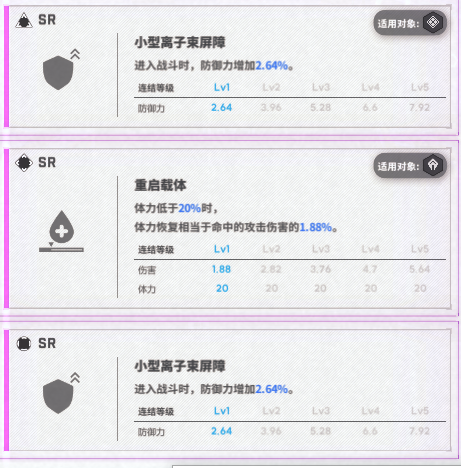

In [379]:
im = gio.get_location_image(loc)
im

In [344]:
buff_rarity_im = agent.image_map['home_ark_simulation_room_buff_rarity_epic']

In [380]:
big_img = to_cv2(im)

# define green value range
big_img_hsv = cv2.cvtColor(big_img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(big_img_hsv, rarity_color, np.array([170,255, 255], dtype=np.uint8))

# find the contours in the mask
contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# find the contour with max area
cnt = sorted(contours, key=cv2.contourArea, reverse=True)
# cv2.drawContours(big_img, [cnt], 0, (0,0,255), 3)

# # Find the bounding box in that region
# x,y,w,h = cv2.boundingRect(cnt)
# buff_side_loc = LocationBox(x,y,w,h)

In [384]:
cnt[0]

array([[[ 6, 34]],

       [[ 5, 35]],

       [[ 6, 36]],

       [[ 6, 37]],

       [[ 5, 38]],

       [[ 5, 40]],

       [[ 7, 40]],

       [[ 7, 38]],

       [[ 6, 37]],

       [[ 6, 36]],

       [[ 7, 35]],

       [[ 7, 34]]], dtype=int32)

In [400]:
for i in cnt:
    to_pil(cv2.drawContours(big_img, [i], 0, (0,0,255), 3))

<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E1E44C0>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E1E44C0>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98DAB7640>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E1E44C0>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98DAB7640>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E1E44C0>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98DAB7640>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E1E44C0>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98DAB7640>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E1E44C0>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98DAB7640>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E1E44C0>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98DAB7640>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E1E44C0>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98DAB7640>
<PIL.Image.Image image mode=RGB size=461x468 at 0x1C98E

In [366]:
buff_side_loc

LocationBox(left=5, top=382, width=3, height=5)

In [356]:
rarity_color = get_image_dominant_color(to_cv2(buff_rarity_im))

In [374]:
def to_cv2(image):
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

def to_pil(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(image)
    return im_pil

In [340]:
def get_image_dominant_color(a):
    colors, count = np.unique(a.reshape(-1,a.shape[-1]), axis=0, return_counts=True)
    return colors[count.argmax()]

In [223]:
loc1 = gio.locate_image(agent.image_map['home_ark_simulation_room_buff_buff_select_icon'], region=agent.location_map['home'].to_bounding())

In [331]:
def simulation_room_select_buff(buff_locs, select_func=None, buff_history=None):
    if not buff_locs:
        return False
    if not select_func:
        return buff_locs[0]
    else:
        buff_loc = select_func(buff_locs)
    return buff_loc
    

def simulation_room_get_buff_count(loc):
    buff_types = ["boss", "choice", "heal", "normal", "upgrade"]
    buff_count = 0
    for buff_type in buff_types:
        buff_locs = gio.locate_image(agent.image_map[f'home_ark_simulation_room_buff_type_{buff_type}'],
                                     region=loc.to_bounding(), multi=True, multi_threshold=0.5)
        if buff_locs:
            print(buff_type)
            print(buff_locs)
            buff_count += len(buff_locs)
    return buff_count

def simulation_room_get_buff_selection():
    buff_icon_loc = gio.locate_image(agent.image_map['home_ark_simulation_room_buff_buff_select_icon'],
                                     region=agent.location_map['home'].to_bounding())
    
    three_buff_loc = loc1.translate(-118, 181).resize(480, 240)
    
    buff_count = simulation_room_get_buff_count(three_buff_loc)
    buff_locs = []
    
    if buff_count == 3:
        buff_1_loc = three_buff_loc.translate(0, 0).resize(160, 240)
        buff_2_loc = three_buff_loc.translate(160, 0).resize(160, 240)
        buff_3_loc = three_buff_loc.translate(320, 0).resize(160, 240)
        buff_locs = [buff_1_loc, buff_2_loc, buff_3_loc]
    elif buff_count == 2:
        buff_1_loc = three_buff_loc.translate(80, 0).resize(160, 240)
        buff_2_loc = three_buff_loc.translate(240, 0).resize(160, 240)
        buff_locs = [buff_1_loc, buff_2_loc]
    elif buff_count == 1:
        buff_1_loc = three_buff_loc.translate(160, 0).resize(160, 240)
        buff_locs = [buff_1_loc]
    
    return buff_locs

def simulation_room_obtain_buff():
    


def simulation_room_battle_session():
    quick_battle = gio.locate_image_and_click(agent.image_map['home_ark_simulation_room_quick_battle'],
                                    region=agent.location_map['home'].to_bounding(),
                                    loop=True, timeout=3)
    if quick_battle:
    
    
    
    if not gio.locate_image_and_click(agent.image_map['home_ark_simulation_room_battle'],
                                    region=agent.location_map['home'].to_bounding(),
                                    loop=True):
        print('could not enter battle')    


def simulation_room_single_battle():
    buff_locs = simulation_room_get_buff_selection()
    if not buff_locs:
        return False
    buff_loc = simulation_room_select_buff(buff_locs)
    gio.mouse_center_click(buff_loc)
    if not gio.locate_image_and_click(agent.image_map['home_ark_simulation_room_buff_battle'],
                                    region=agent.location_map['home'].to_bounding(),
                                    loop=True):
        print('could not enter battle')
    
    
    

In [332]:
agent.location_map['home']

LocationBox(left=27, top=66, width=575, height=1022)

In [333]:
simulation_room_single_battle()

normal
[LocationBox(left=204, top=663, width=57, height=50), LocationBox(left=366, top=663, width=57, height=50)]


In [230]:
three_buff_loc = loc1.translate(-118, 181).resize(480, 240)
three_buff_loc

LocationBox(left=74, top=634, width=480, height=240)

In [234]:
buff_1_loc = three_buff_loc.translate(0, 0).resize(160, 240)
buff_2_loc = three_buff_loc.translate(160, 0).resize(160, 240)
buff_3_loc = three_buff_loc.translate(320, 0).resize(160, 240)

In [242]:
buff_1_loc = three_buff_loc.translate(80, 0).resize(160, 240)
buff_2_loc = three_buff_loc.translate(240, 0).resize(160, 240)

In [ ]:
buff_1_loc = three_buff_loc.translate(160, 0).resize(160, 240)

In [313]:
simulation_room_get_buff_count(three_buff_loc)

normal
[LocationBox(left=204, top=663, width=57, height=50), LocationBox(left=366, top=663, width=57, height=50)]


2

In [308]:
locs = non_maximum_suppresion(buff_locs)

In [309]:
locs

[LocationBox(left=204, top=663, width=57, height=50),
 LocationBox(left=366, top=663, width=57, height=50)]

In [285]:
buff_locs = gio.locate_image(agent.image_map[f'home_ark_simulation_room_buff_type_normal'],
                                     region=loc.to_bounding(), multi=True, multi_threshold=0.5)

In [286]:
buff_locs

[LocationBox(left=204, top=661, width=57, height=50),
 LocationBox(left=366, top=661, width=57, height=50),
 LocationBox(left=203, top=662, width=57, height=50),
 LocationBox(left=365, top=662, width=57, height=50),
 LocationBox(left=204, top=663, width=57, height=50),
 LocationBox(left=366, top=663, width=57, height=50)]

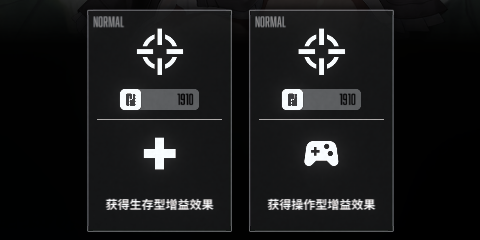

In [257]:
im = gio.get_location_image(three_buff_loc)
im

In [208]:
result = gio.read_text(im)
result

[[[[19, 27], [67, 27], [67, 47], [19, 47]], '模拟室'],
 [[[196, 24], [254, 24], [254, 48], [196, 48]], '6% +'],
 [[[358, 24], [404, 24], [404, 48], [358, 48]], '4BRK'],
 [[[69, 89], [137, 89], [137, 109], [69, 109]], '湎关奖励'],
 [[[469, 89], [535, 89], [535, 109], [469, 109]], '〈川结吏'],
 [[[200, 389], [274, 389], [274, 422], [200, 422]], '31UUL uTII ROOM'],
 [[[364, 394], [414, 394], [414, 420], [364, 420]], '5-C'],
 [[[219, 445], [323, 445], [323, 477], [219, 477]], 'RE 5 ET TIHE 162112'],
 [[[57, 587], [81, 587], [81, 601], [57, 601]], '州'],
 [[[131, 661], [163, 661], [163, 677], [131, 677]], '1g'],
 [[[293, 661], [325, 661], [325, 677], [293, 677]], 'B0g'],
 [[[457, 661], [487, 661], [487, 677], [457, 677]], 'U0g'],
 [[[105, 711], [169, 711], [169, 731], [105, 731]], ',丛 囚'],
 [[[69, 763], [181, 763], [181, 781], [69, 781]], '获得[人]型增益效果'],
 [[[231, 763], [343, 763], [343, 781], [231, 781]], '获得[0]型增苓效果'],
 [[[391, 762], [505, 762], [505, 780], [391, 780]], '获得操作型增益效累'],
 [[[45, 841], [127

In [46]:
agent.advise_nikke_single_round()

 2023-02-17 16:29:09,729 - INFO - started a round of advising nikkes
 2023-02-17 16:29:12,175 - INFO - started advising 德雷克


LocationBox(left=65, top=505, width=14, height=37)
LocationBox(left=65, top=505, width=264.0, height=37)


 2023-02-17 16:29:56,043 - INFO - No more sessions available today
 2023-02-17 16:30:00,752 - INFO - ended a round of advising nikkes


(True,
 {'长发公主': {'location': LocationBox(left=66, top=520, width=264.0, height=37),
   'advised': False},
  '德雷克': {'location': LocationBox(left=65, top=505, width=264.0, height=37),
   'advised': True}},
 ['德雷克'])

In [119]:
power_level_loc = gio.locate_image(agent.image_map['home_ark_arena_rookie_power_level'],
                region=agent.location_map['home'].to_bounding(), confidence=0.7, multi=True)

In [120]:
power_level_loc[1]

[LocationBox(left=226, top=303, width=22, height=24),
 LocationBox(left=436, top=346, width=22, height=24)]

In [400]:
loc = gio.locate_image(agent.image_map['confirm'],
                        region=agent.location_map['home'].to_bounding(), confidence=0.8)

In [412]:
loc = gio.locate_image_and_click(agent.image_map['confirm'],
                                                    region=agent.location_map['home'].to_bounding(), loop=True)

In [419]:
loc = gio.locate_image_and_click(agent.image_map['home_advise_advise'], region=agent.location_map['home'].to_bounding(),
                                        loop=True, confidence=0.9, timeout=2)

In [62]:
gio.locate_image(agent.image_map['home_ark_arena_rookie_power_level'],
                        region=agent.location_map['home'].to_bounding(), confidence=0.7)

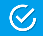

In [401]:
im = gio.get_location_image(loc)
im

In [339]:
pytesseract.image_to_string(im,
                        config='--psm 11 outputbase digits tessedit_char_whitelist=0123456789').strip().replace(" ", "")

'542'

In [141]:
gio.read_text(im)

[[[[2, 2], [38, 2], [38, 28], [2, 28]], '1踯']]

In [71]:
gio.locate_image(agent.image_map['home_ark_arena_rookie_free'], region=agent.location_map['home'].to_bounding(), multi=True)

[LocationBox(left=595, top=722, width=53, height=30),
 LocationBox(left=594, top=860, width=53, height=30),
 LocationBox(left=594, top=998, width=53, height=30)]

In [207]:
max([954, 99542, 954])

99542

In [353]:
a = agent.rookie_arena_get_self_information()
a

[1936, 1336, 936, 1936, 1336]
LocationBox(left=471, top=481, width=41, height=30)
[99542, 99542, 99542, 99542, 99542, 99542, 5542]


{'rank': 1936, 'power_level': 99542}

In [354]:
b = agent.rookie_arena_get_enemy_information()
b

[28, 28, 28, 28]
[101, 101, 1501, 1501, 101, 4, 1501]
[1709, 1709, 1709]
[118451, 118451, 18451, 8, 118451, 118451, 118451, 18451]
[74279, 74279, 14279, 14279, 74279, 74279, 74279, 14279]
[73436, 73436, 736, 5, 73436, 73436, 73436, 736]


{0: {'rank': 28,
  'power_level': 118451,
  'fight_loc': LocationBox(left=484, top=727, width=43, height=25)},
 1: {'rank': 1501,
  'power_level': 74279,
  'fight_loc': LocationBox(left=484, top=838, width=43, height=25)},
 2: {'rank': 1709,
  'power_level': 73436,
  'fight_loc': LocationBox(left=485, top=949, width=43, height=25)}}

In [356]:
agent.select_opponent(a,b)

 2023-02-16 21:12:35,276 - INFO - Opponent information valid
 2023-02-16 21:12:35,277 - INFO - Opponent select with power level 73436 and rank 1709


{'rank': 1709,
 'power_level': 73436,
 'fight_loc': LocationBox(left=485, top=949, width=43, height=25)}

In [21]:
gio.locate_image(agent.image_map['home_advise_home'], region=agent.location_map['home'].to_bounding())

LocationBox(left=344, top=193, width=40, height=40)

In [22]:
gio.locate_image_and_click(agent.image_map['home_advise_home'],
                                                  region=agent.location_map['home'].to_bounding(), loop=True, timeout=3)

True

In [15]:
agent.advise_nikke()

 2023-02-16 16:18:09,162 - INFO - advising nikkes start
 2023-02-16 16:18:15,900 - WARNING - advising nikkes failed because the advise icon is not found


False

In [18]:
agent.rookie_arena()

 2023-02-18 17:24:51,901 - INFO - rookie arena run start
 2023-02-18 17:25:04,597 - INFO - Retrieving rookie arena information


LocationBox(left=591, top=421, width=51, height=37)


 2023-02-18 17:25:06,861 - INFO - Seems like no more free battles. Retrying...
 2023-02-18 17:25:06,974 - INFO - Seems like no more free battles. Retrying...
 2023-02-18 17:25:07,100 - INFO - Seems like no more free battles. Retrying...
 2023-02-18 17:25:07,221 - INFO - No more free battle available
 2023-02-18 17:25:07,222 - INFO - rookie arena run end
 2023-02-18 17:25:07,222 - INFO - Exiting to home...


In [94]:
if (gio.locate_image(agent.image_map['home_blabla']) and
gio.locate_image(agent.image_map['home_friend']) and
   gio.locate_image(agent.image_map['home_union'])):
    print("a")

a


In [175]:
item_list = [agent.image_map['home_blabla'],agent.image_map['home_friend'],agent.image_map['home_union']]

In [183]:
loc = gio.exist_image(item_list, region=agent.location_map['home'].to_bounding())

In [197]:
def exit_to_home():
    item_list = [agent.image_map['home_blabla'],agent.image_map['home_friend'],agent.image_map['home_union']]
    while gio.exist_image(item_list, region=agent.location_map['home'].to_bounding()) is False:
        gio.single_click("esc")
        gio.delay(1)

In [213]:
gio.locate_image_and_click(agent.image_map['home_outpost_express'],
                           region=agent.location_map['home'].to_bounding())
gio.locate_image_and_click(agent.image_map['home_outpost_express_obtain_reward'],
                           region=agent.location_map['home'].to_bounding(), loop=True)
potential_actions = [agent.image_map['home_outpost_express_reward'],
                     agent.image_map['home_outpost_express_confirm'],
                     agent.image_map['home_outpost_express_level_up']]
gio.locate_image_and_click(potential_actions,
                           region=agent.location_map['home'].to_bounding(), loop=True)
exit_to_home()

In [257]:
gio.locate_image_and_click(agent.image_map['home_friend'],
                           region=agent.location_map['home'].to_bounding())
gio.exist_image(agent.image_map['home_friend_send_ready'], region=agent.location_map['home'].to_bounding(), loop=True)

if not gio.exist_image(agent.image_map['home_friend_send_not_ready'], region=agent.location_map['home'].to_bounding(), loop=True, timeout=2):
    gio.locate_image_and_click(agent.image_map['home_friend_send'],
                               region=agent.location_map['home'].to_bounding(), loop=True)
    gio.locate_image_and_click(agent.image_map['confirm'],
                               region=agent.location_map['home'].to_bounding())

In [7]:
agent.daily()

 2023-02-15 15:02:47,658 - INFO - claiming outpost reward start
 2023-02-15 15:02:54,512 - INFO - Checking if outpost wipe is available


single clicking esc


 2023-02-15 15:03:14,899 - INFO - Performed 1 outpost wipe
 2023-02-15 15:03:17,329 - INFO - claiming outpost reward end successful


single clicking esc
single clicking esc


In [242]:
agent.location_map['home']

LocationBox(left=48, top=179, width=575, height=1022)

In [299]:
im = gio.locate_image(agent.image_map['home_outpost_express'], region=agent.location_map['home'].to_bounding(), confidence=0.8)

In [300]:
gio.get_location_image(im)

In [301]:
agent.image_map['home_outpost_express']

In [13]:
gio.locate_image_and_click(agent.image_map['home_outpost_express'],
                           region=agent.location_map['home'].to_bounding(), confidence=0.8)

True

In [10]:
app_list = gw.getWindowsAt(*gio.get_image_center(agent.location_map['home']))
app = [app for app in app_list if app.title == agent.NIKKE_PC_WINDOW][0]
app.activate()


gio.locate_image_and_click(agent.image_map['home_outpost_express'],
                           region=agent.location_map['home'].to_bounding(), confidence=0.8)

True

In [285]:
print(app)

<Win32Window left="40", top="148", width="591", height="1061", title="NIKKE">


In [252]:
import pydirectinput as p

In [256]:
p.doubleClick()

In [259]:
def left_click(delay=0.5):
    pyautogui.click(button='left')
    gio.delay(delay)
    pyautogui.mouseUp(button='left')

In [272]:
import pygetwindow as gw

win = gw.getWindowsWithTitle('NIKKE')[0]
win.activate()
aw = gw.getActiveWindow()
print(aw)

<Win32Window left="835", top="99", width="1462", height="1276", title="Nikke - Jupyter Notebook - Google Chrome">


In [275]:
print(win)

<Win32Window left="835", top="99", width="1462", height="1276", title="Nikke - Jupyter Notebook - Google Chrome">


<Win32Window left="835", top="99", width="1462", height="1276", title="Nikke - Jupyter Notebook - Google Chrome">


In [292]:
app_list = gw.getWindowsAt(*gio.get_image_center(agent.location_map['home']))
app = [app for app in app_list if app.title == agent.NIKKE_PC_WINDOW][0]
app.activate()

In [286]:
[print(w) for w in win]

<Win32Window left="40", top="148", width="591", height="1061", title="NIKKE">
<Win32Window left="0", top="0", width="2560", height="1440", title="">
<Win32Window left="0", top="0", width="2560", height="1440", title="Microsoft Text Input Application">
<Win32Window left="0", top="0", width="2560", height="1440", title="Program Manager">


[None, None, None, None]

In [15]:
import admin
if not admin.isUserAdmin():
    admin.runAsAdmin()
app_list = gw.getWindowsAt(*gio.get_image_center(agent.location_map['home']))
app = [app for app in app_list if app.title == agent.NIKKE_PC_WINDOW][0]
app.activate()


gio.locate_image_and_click(agent.image_map['home_outpost_express'],
                           region=agent.location_map['home'].to_bounding(), confidence=0.8)

True

In [54]:
ADVISE_AMOUT_TEXT = '咨询次数'
if not gio.exist_image(agent.image_map['home_advise_home'], loop=True, timeout=3):
    agent.logger.info('Leaving advising because not in advising UI')
im = gio.get_location_image(agent.location_map['home'])
result = gio.read_text(im, detail=0)
available_advise_session = int([result[ind+1] for ind, s in enumerate(result) if s==ADVISE_AMOUT_TEXT][0].strip()[0])

In [63]:
a = agent.advise_check_available_session()

In [64]:
a

0

In [65]:
agent.advise_nikke()

 2023-02-15 15:57:38,512 - INFO - advising nikkes start
 2023-02-15 15:57:42,932 - INFO - started a round of advising nikkes
 2023-02-15 15:57:45,625 - INFO - No more sessions available today
 2023-02-15 15:57:50,337 - INFO - No more new nikkes to advise
 2023-02-15 15:57:50,337 - INFO - ended a round of advising nikkes
 2023-02-15 15:57:50,338 - INFO - advising nikkes end successful


In [161]:
app_list = gw.getWindowsAt(*gio.get_image_center(agent.location_map['home']))
app = [app for app in app_list if app.title == agent.NIKKE_PC_WINDOW][0]
app.activate()

In [163]:
app.resize()

In [165]:
app.size

Size(width=414, height=747)

In [291]:
agent.location_map['home']

LocationBox(left=48, top=179, width=575, height=1022)

In [287]:
app.resize()

TypeError: Win32Window.resize() missing 2 required positional arguments: 'widthOffset' and 'heightOffset'

In [ ]:
def retry_action(timeout=3, delay=3):
    def post_action(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            attempt = 0
            while attempt < timeout:
                try:
                    retval = function(*args, **kwargs)
                    return retval
                except Exception as e:
                    self.logger.error(e)
                    GameInteractionIO.delay(delay)
            raise e
        return wrapper
    return post_action